## Experiment E4: GPT-5.1 vs Reasoning Orchestrator-8B Comparison
- Date: 2025-01-30
- Author: akshay@getseer.dev
- **Update:** Orchestrator-8B now uses System 2 reasoning (similar to o1/DeepSeek-R1) with enforced thinking protocols

### 1. Hypothesis
- **$H_0$:** GPT-5.1 and Orchestrator-8B perform equivalently on agentic tool-using tasks.
- **$H_1$:** Reasoning-enabled Orchestrator-8B (System 2 thinking) compensates for GPT-5.1's advantages and performs competitively or better on complex multi-turn agentic tasks.

### 2. Experimental Setup
* **Environment:** Docker (Linux) + RunPod (vLLM API server)
* **Workload:** Agentic tasks requiring tool orchestration (5 tasks: Google Docs/Sheets, Calendar/Slack, Gmail, Telegram, Twitter)
* **Agent Architecture:** LangGraph ReAct Agent with LLM-as-Judge evaluation
* **Orchestrator-8B Configuration:**
    * **Reasoning Mode:** System 2 thinking enforced via system prompt
    * **Temperature:** 0.5 (increased from 0.2 for reasoning exploration)
    * **Max Tokens:** 8192 (increased from 4096 for longer reasoning traces)
    * **Recursion Limit:** 75 (increased from 25 to allow more thinking iterations)
* **Variables:**
    * *Independent:* LLM model (GPT-5.1 vs Reasoning Orchestrator-8B)
    * *Controlled:* Agent (LangGraph ReAct), Tools (Composio MCP), Evaluation (LLM-as-Judge)
    * *Dependent:* 
        - Task success rate
        - Token usage (input/output tokens)
        - Agent performance metrics (score, groundedness, confabulation)

### 3. Procedure
1. **Setup:** 
   - Fetch Composio MCP tools per task (cached for efficiency)
   - Initialize both models (GPT-5.1 via OpenAI API, Orchestrator-8B via vLLM server)
   - Initialize LangGraph ReAct agent with model-specific system prompts
   - Initialize LLM-as-Judge evaluator
2. **Run:** 
   - For each task, run experiments with both models (4 runs per task per model)
   - Execute tasks using the ReAct agent with increased recursion limits
   - Track token usage for both models
   - Evaluate responses using LLM-as-Judge
3. **Analysis:** 
   - Compare task success rates
   - Compare token usage and costs
   - Analyze agent performance metrics

### 4. Evaluation Metrics
- **Task Success Rate:** Percentage of tasks completed successfully (PASS status)
- **Score:** LLM-as-Judge score (0.0-1.0)
- **Token Usage:** Input/output tokens per model
- **Groundedness:** Whether response is grounded in tool outputs
- **Confabulation:** Whether agent claimed success without evidence

### 5. Final Results
**Experiment completed:** 5 tasks × 2 runs × 2 models = 20 total runs

#### Overall Performance Summary
- **GPT-5.1:**
  - Success Rate: **80.0%** (8/10 tasks passed)
  - Average Score: **0.87 ± 0.24**
  - Confabulation Rate: **0.0%**
  - Groundedness Rate: **100.0%**
  - Average Token Usage: **2,412 ± 1,020 tokens**

- **Orchestrator-8B:**
  - Success Rate: **60.0%** (6/10 tasks passed)
  - Average Score: **0.70 ± 0.34**
  - Confabulation Rate: **20.0%**
  - Groundedness Rate: **60.0%**
  - Average Token Usage: **3,883 ± 1,190 tokens**

#### Task-by-Task Breakdown
1. **Google Docs → Sheets:** GPT-5.1 (100%) vs Orchestrator-8B (50%)
2. **Calendar + Slack:** GPT-5.1 (100%) vs Orchestrator-8B (100%)
3. **Gmail Reminder:** GPT-5.1 (100%) vs Orchestrator-8B (100%)
4. **Telegram Message:** GPT-5.1 (0%) vs Orchestrator-8B (0%) - Both failed
5. **Twitter Trends:** GPT-5.1 (100%) vs Orchestrator-8B (50%)

#### Key Findings
- **GPT-5.1** demonstrated superior overall performance with higher success rates, better scores, and perfect groundedness (no confabulation).
- **Orchestrator-8B** showed competitive performance on some tasks (Calendar/Slack, Gmail) but struggled with consistency, exhibiting higher confabulation rates and lower groundedness.
- **Token Usage:** Orchestrator-8B used ~61% more tokens on average, reflecting its reasoning-based approach but without proportional performance gains.
- **Hypothesis Result:** $H_0$ cannot be rejected - GPT-5.1 significantly outperformed Reasoning Orchestrator-8B overall, though Orchestrator-8B showed promise on specific task types.

## Prerequisites


In [1]:
%pip install matplotlib seaborn pandas numpy langgraph langchain-core langchain-openai requests


Note: you may need to restart the kernel to use updated packages.


## Import Statements


In [2]:
import os
import json
import re
import logging
from typing import List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.tools import BaseTool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from composio import Composio
from composio_langchain import LangchainProvider
from langchain.agents import create_agent

load_dotenv()
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
sns.set_theme(style="whitegrid")


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
import re
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import BaseMessage, AIMessage
from langchain_core.outputs import ChatGeneration, ChatResult
from typing import List, Any, Optional
from pydantic import ConfigDict


class ReasoningTokenStripper(BaseChatModel):
    """
    Wrapper that strips reasoning tokens (<think>, <think>, etc.) 
    from Orchestrator-8B responses to ensure tool calls are properly parsed.
    """
    model_config = ConfigDict(arbitrary_types_allowed=True, extra='allow')
    
    def __init__(self, base_model: BaseChatModel, **kwargs):
        # Initialize with extra='allow' so we can store base_model
        super().__init__(**kwargs)
        # Store base_model as a regular attribute (allowed with extra='allow')
        object.__setattr__(self, 'base_model', base_model)
        
    def _strip_reasoning_tokens(self, text: str) -> str:
        """Remove reasoning tokens and tags from response text."""
        if not text:
            return text
        
        # Remove <think>...</think> blocks (with any whitespace)
        text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL | re.IGNORECASE)
        
        # Remove standalone tags (unclosed)
        text = re.sub(r'</?redacted_reasoning>', '', text, flags=re.IGNORECASE)
        text = re.sub(r'</?think>', '', text, flags=re.IGNORECASE)
        text = re.sub(r'</?reasoning>', '', text, flags=re.IGNORECASE)
        
        # Clean up extra whitespace and newlines
        text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)
        text = text.strip()
        
        return text
    
    def _generate(self, messages: List[BaseMessage], stop: Optional[List[str]] = None, **kwargs: Any) -> ChatResult:
        """Generate response and strip reasoning tokens."""
        result = self.base_model._generate(messages, stop=stop, **kwargs)
        
        # Strip reasoning tokens from all generations
        for generation in result.generations:
            if isinstance(generation, ChatGeneration):
                if hasattr(generation, 'message') and isinstance(generation.message, AIMessage):
                    if generation.message.content:
                        original_content = generation.message.content
                        cleaned_content = self._strip_reasoning_tokens(str(original_content))
                        
                        # Only update if content changed (to preserve tool_calls if present)
                        if cleaned_content != original_content:
                            # Create new AIMessage with cleaned content but preserve tool_calls
                            generation.message = AIMessage(
                                content=cleaned_content,
                                tool_calls=getattr(generation.message, 'tool_calls', None),
                                tool_call_id=getattr(generation.message, 'tool_call_id', None),
                                response_metadata=getattr(generation.message, 'response_metadata', None),
                            )
        
        return result
    
    def invoke(self, input: List[BaseMessage], config: Optional[Any] = None, **kwargs: Any) -> BaseMessage:
        """Invoke model and strip reasoning tokens from response."""
        response = self.base_model.invoke(input, config=config, **kwargs)
        
        if isinstance(response, AIMessage) and response.content:
            original_content = str(response.content)
            cleaned_content = self._strip_reasoning_tokens(original_content)
            
            if cleaned_content != original_content:
                # Preserve tool_calls and other attributes
                return AIMessage(
                    content=cleaned_content,
                    tool_calls=getattr(response, 'tool_calls', None),
                    tool_call_id=getattr(response, 'tool_call_id', None),
                    response_metadata=getattr(response, 'response_metadata', None),
                )
        
        return response
    
    def bind_tools(self, tools, **kwargs):
        """Delegate bind_tools to base model and wrap the result."""
        bound_model = self.base_model.bind_tools(tools, **kwargs)
        # Return a new wrapper with the bound model
        return ReasoningTokenStripper(bound_model)
    
    @property
    def _llm_type(self) -> str:
        return "reasoning_token_stripper"
    
    @property
    def model_name(self) -> str:
        """Delegate model_name to base model."""
        return getattr(self.base_model, 'model_name', 'orchestrator-8b')

# RunPod proxy URL (exposes port 8000)
orchestrator_api_url = "https://c1nw2aqzf8ifzc-8000.proxy.runpod.net"

# Test connection first
import requests
try:
    response = requests.get(f"{orchestrator_api_url}/health", timeout=5)
    if response.status_code == 200:
        print(f"✅ Orchestrator server found at {orchestrator_api_url}")
        print(f"   Status: {response.json()}")
    else:
        print(f"⚠️ Orchestrator server returned status {response.status_code}")
        orchestrator_api_url = None
except Exception as e:
    print(f"⚠️ Could not connect to Orchestrator server at {orchestrator_api_url}: {e}")
    print("   Make sure orchestrator_vllm_simple.py is running!")
    orchestrator_api_url = None

models_to_compare = {
    "gpt-5.1": ChatOpenAI(model="gpt-5.1", reasoning={"effort": "low"}),
}

if orchestrator_api_url:
    from langchain_openai import ChatOpenAI
    from langchain_core.messages import SystemMessage
    import os

    # REASONING SYSTEM PROMPT: Enforce System 2 thinking for Orchestrator-8B
    # This transforms Orchestrator into a reasoning model similar to o1/DeepSeek-R1
    REASONING_SYSTEM_PROMPT = """You are a deep reasoning engine operating in System 2 mode (deliberate, analytical thinking).

CORE DIRECTIVE: You must NEVER answer or call tools immediately. You MUST first enter a "Thinking Process" to deconstruct the query, verify assumptions, and plan your response.

THE REASONING PROTOCOL:
1. **Initiate Thinking**: Start every response with <think> or <think> tag.
2. **Deconstruct**: Break the user's prompt into atomic logical claims or required steps.
3. **Hypothesize & Verify**: Propose a solution path. Then, within the think block, critically critique that path. Look for flaws. If a flaw is found, backtrack and try a new path.
4. **Plan Tool Usage**: Before calling any tool, reason about:
   - Which tool(s) are needed and why
   - What parameters each tool requires
   - What the expected output should be
   - How tool outputs will be combined to solve the task
5. **Draft**: Draft the final response internally.
6. **Final Output**: Close the </think> or </think> tag and provide only the verified, high-quality final answer or tool call.

CRITICAL RULES:
- ALWAYS think before acting. Use test-time compute to simulate multiple solution paths.
- Trade time for intelligence: Generate thorough reasoning traces before producing answers.
- Self-correct: If your reasoning reveals a flaw, backtrack and try again.
- Be thorough: Complex problems require more reasoning tokens. Use them.

Remember: You are a reasoning model. Your strength comes from deliberate thinking, not speed."""

    # Create base Orchestrator model with reasoning configuration
    base_orchestrator = ChatOpenAI(
        model="orchestrator-8b",  # Model name (doesn't matter, server uses loaded model)
        base_url=f"{orchestrator_api_url}/v1",  # Our FastAPI server endpoint
        api_key="not-needed",  # No auth needed
        temperature=0.5,  # Increased from 0.2 to 0.5 for reasoning exploration
        max_tokens=8192,  # Increased from 4096 to allow longer reasoning traces
        timeout=180,  # Increased timeout for slower reasoning responses
    )
    
    # Wrap Orchestrator model to strip reasoning tokens (double protection)
    # Server already strips, but this ensures clean responses in LangChain
    models_to_compare["orchestrator-8b"] = ReasoningTokenStripper(base_orchestrator)
    
    # Store reasoning prompt for later use in system prompts
    models_to_compare["orchestrator-8b"].reasoning_prompt = REASONING_SYSTEM_PROMPT
    
    print("\n✅ Models initialized")
    print(f"   GPT-5.1: Ready")
    print(f"   Orchestrator-8B: Ready (REASONING MODE enabled, with reasoning token stripping)")
    print(f"   Reasoning config: temperature=0.5, max_tokens=8192")
else:
    print("\n⚠️ Orchestrator-8B not initialized (server not available)")
    print("   Continuing with GPT-5.1 only...")
    

✅ Orchestrator server found at https://c1nw2aqzf8ifzc-8000.proxy.runpod.net
   Status: {'status': 'healthy', 'model': '/workspace/.cache/huggingface/hub/models--nvidia--Orchestrator-8B/snapshots/0659490ee395888c86c24529e1723a26763433c9', 'engine': 'vLLM'}

✅ Models initialized
   GPT-5.1: Ready
   Orchestrator-8B: Ready (REASONING MODE enabled, with reasoning token stripping)
   Reasoning config: temperature=0.5, max_tokens=8192


## Configuration & Setup


In [ ]:
# --- Configuration ---
COMPOSIO_API_KEY = os.getenv("COMPOSIO_API_KEY")
COMPOSIO_USER_ID = os.getenv("COMPOSIO_USER_ID")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Experiment Parameters
NUM_RUNS = 3  # Number of runs per task per method (total runs = NUM_RUNS * 2 methods)
MAX_TOOLS_PER_TASK = 50  # Limit to prevent OpenAI context errors (max 128)
TOP_K_TOOLS = 5

# Experiment Tasks
# NOTE: Using complex multi-step tasks to better evaluate model capabilities
# These tasks require coordination across multiple services and have error-prone operations
# that better showcase differences between GPT-5.1 and Orchestrator-8B

# SIMPLE TASKS (baseline - both models should perform similarly)
SIMPLE_TASKS = [
    {
        "instruction": "send good morning message to +1 646-371-6198 via telegram",
        "metric": "Check API response 200 OK from Telegram.",
        "services": ["TELEGRAM"],
        "complexity": "simple"
    },
    {
        "instruction": "what are the latest trends going on twitter",
        "metric": "Check Twitter API for post results.",
        "services": ["TWITTER"],
        "complexity": "simple"
    },
]

# COMPLEX TASKS (better evaluation of model capabilities)
# These tasks have multiple steps, error-prone operations, and require coordination
COMPLEX_TASKS = [
    {
        "instruction": """Create a weekly work summary: 
1. Get my Google Calendar events for next week
2. Get my GitHub pull requests from last week (all repos)
3. Get my Slack messages from #engineering channel from last week
4. Combine all information into a structured Google Doc
5. Share the document with my manager (look up their email)
6. Send them a Slack notification with the doc link""",
        "metric": "Check for: (1) Google Doc created with all data, (2) Doc shared with manager, (3) Slack notification sent",
        "services": ["GOOGLECALENDAR", "GITHUB", "SLACK", "GOOGLEDOCS"],
        "complexity": "complex",
        "expected_failure_modes": [
            "Wrong date format for calendar query",
            "GitHub API pagination (only gets first 30 PRs)",
            "Slack channel search might need different query format",
            "Doc sharing might fail (wrong email lookup)",
            "Slack notification might fail (wrong user ID format)"
        ]
    },
    {
        "instruction": """Find all unread emails from last month that contain 'meeting' or 'urgent',
extract any action items or deadlines mentioned,
create a prioritized task list in Google Sheets with columns: Task, Deadline, Priority,
and send me a summary email with the sheet link""",
        "metric": "Check for: (1) Google Sheet created with tasks, (2) Summary email sent",
        "services": ["GMAIL", "GOOGLESHEETS"],
        "complexity": "complex",
        "expected_failure_modes": [
            "Gmail API date format (needs YYYY-MM-DD, not MM/DD/YYYY)",
            "Email search query might need different syntax",
            "Sheet creation might fail (wrong format)",
            "Deadline extraction might miss some dates",
            "Email sending might fail (wrong recipient format)"
        ]
    },
    {
        "instruction": """Find all GitHub issues assigned to me that mention 'bug' or 'error',
check if any have related Slack discussions in #bugs channel,
create a summary document with: issue title, description, and related Slack context,
and post it to #engineering channel with priority tags based on issue labels""",
        "metric": "Check for: (1) Summary doc created, (2) Message posted to #engineering with doc link",
        "services": ["GITHUB", "SLACK", "GOOGLEDOCS"],
        "complexity": "complex",
        "expected_failure_modes": [
            "GitHub API pagination (only gets first 30 issues)",
            "Slack search might need different query format",
            "Matching issues to Slack threads (fuzzy matching needed)",
            "Doc creation might fail (wrong template)",
            "Slack posting might fail (wrong channel format)"
        ]
    },
]

# Use complex tasks for better evaluation (simple tasks are just baseline)
TASKS = COMPLEX_TASKS  # Change to SIMPLE_TASKS for baseline comparison

CACHED_SYSTEM_PROMPT = """
You are an expert AI Assistant and QA Auditor.
Your goal is to execute tasks using the provided tools and then reflect on your performance.

### CORE INSTRUCTIONS
1. **Analyze the Request**: Understand the user's intent and the success metric.
2. **Select Tools**: Choose the most appropriate tools from your available toolkit.
3. **Execute**: Run the tools and observe the output.
4. **Verify**: Check if the output satisfies the success metric.
5. **Reflect**: If a tool fails or produces unexpected results, analyze why and try a different approach.

### RESPONSE GUIDELINES
- Be concise and direct.
- Do not hallucinate tool outputs; only use what is returned by the tools.
- If a tool is missing, explicitly state that you cannot perform the task.
- Always check the tool output against the success metric before claiming success.
"""

# Reasoning system prompt for Orchestrator-8B (System 2 thinking)
REASONING_SYSTEM_PROMPT = """You are a deep reasoning engine operating in System 2 mode (deliberate, analytical thinking).

CORE DIRECTIVE: You must NEVER answer or call tools immediately. You MUST first enter a "Thinking Process" to deconstruct the query, verify assumptions, and plan your response.

THE REASONING PROTOCOL:
1. **Initiate Thinking**: Start every response with <think> or <think> tag.
2. **Deconstruct**: Break the user's prompt into atomic logical claims or required steps.
3. **Hypothesize & Verify**: Propose a solution path. Then, within the think block, critically critique that path. Look for flaws. If a flaw is found, backtrack and try a new path.
4. **Plan Tool Usage**: Before calling any tool, reason about:
   - Which tool(s) are needed and why
   - What parameters each tool requires
   - What the expected output should be
   - How tool outputs will be combined to solve the task
5. **Draft**: Draft the final response internally.
6. **Final Output**: Close the </think> or </think> tag and provide only the verified, high-quality final answer or tool call.

CRITICAL RULES:
- ALWAYS think before acting. Use test-time compute to simulate multiple solution paths.
- Trade time for intelligence: Generate thorough reasoning traces before producing answers.
- Self-correct: If your reasoning reveals a flaw, backtrack and try again.
- Be thorough: Complex problems require more reasoning tokens. Use them.

Remember: You are a reasoning model. Your strength comes from deliberate thinking, not speed."""


In [5]:
# OPTIMIZED VERSION: Replace filter_tools_with_llm function with this optimized version
# This reduces Orchestrator-8B token usage significantly

def filter_tools_with_llm_optimized(
    task: Dict[str, Any],
    all_tools: List[BaseTool],
    model,
    top_k: int = 10
) -> tuple[List[BaseTool], Dict[str, Any]]:
    """Optimized version - uses shorter prompts for Orchestrator-8B."""
    model_name = getattr(model, 'model_name', 'unknown')
    is_orchestrator = 'orchestrator' in model_name.lower()
    
    # Prepare tool descriptions
    tool_descriptions = [{"name": tool.name, "description": tool.description or ""} for tool in all_tools]
    
    # Create optimized prompt based on model
    if is_orchestrator:
        # Ultra-concise prompt for Orchestrator (reduces reasoning/verbosity)
        prompt = f"""Task: {task['instruction']}
Metric: {task.get('metric', 'N/A')}

Select {top_k} tools from: {json.dumps([t['name'] for t in tool_descriptions], indent=0)}

Return ONLY JSON array: ["tool1", "tool2", ...]"""
    else:
        # Standard prompt for GPT models
        prompt = f"""You are a tool selection expert. Given a task and a list of available tools, select the most relevant tools needed to complete the task.

TASK:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AVAILABLE TOOLS ({len(all_tools)} total):
{json.dumps(tool_descriptions, indent=2)}

Select the top {top_k} most relevant tools for this task. Consider:
1. Which tools are directly required to complete the task?
2. Which tools might be needed as dependencies or helpers?
3. Rank tools by importance (most critical first)

Return a JSON array of tool names in order of relevance (most relevant first).
Format: ["tool_name_1", "tool_name_2", ...]
"""
    
    token_usage = {"input_tokens": 0, "output_tokens": 0}
    print(f"   📤 Sending tool selection request to LLM (model: {model_name})...")
    
    # Give Orchestrator enough tokens to complete the response (it may include reasoning)
    # Increased from 128 to 2048 to match GPT and allow for reasoning tokens
    max_tokens = 2048 if is_orchestrator else 1024
    try:
        response = model.invoke([HumanMessage(content=prompt)], max_tokens=max_tokens)
        print(f"   ⏳ Got response, parsing...")
    except Exception as e:
        print(f"   ❌ Error calling model: {e}")
        # Try to get raw response for debugging
        if is_orchestrator and hasattr(model, 'client'):
            try:
                # Try to make a direct request to see raw response
                import requests
                api_url = getattr(model, '_client', None)
                if api_url is None:
                    # Try to extract from base_url
                    base_url = getattr(model, 'base_url', None)
                    if base_url:
                        # Make a test request to see what we get
                        test_response = requests.post(
                            f"{base_url}/chat/completions",
                            json={
                                "messages": [{"role": "user", "content": "test"}],
                                "temperature": 0.2,
                                "max_tokens": 10
                            },
                            headers={"Authorization": f"Bearer {getattr(model, 'api_key', 'not-needed')}"},
                            timeout=10
                        )
                        print(f"   🔍 Raw HTTP response status: {test_response.status_code}")
                        print(f"   🔍 Raw HTTP response body: {test_response.text[:500]}")
            except Exception as debug_e:
                print(f"   ⚠️ Could not fetch raw response: {debug_e}")
        raise
    
    # Extract token usage
    token_found = False
    if hasattr(response, 'response_metadata') and response.response_metadata:
        usage = response.response_metadata.get('token_usage', {})
        if usage:
            token_usage["input_tokens"] = usage.get('prompt_tokens', 0) or usage.get('input_tokens', 0)
            token_usage["output_tokens"] = usage.get('completion_tokens', 0) or usage.get('output_tokens', 0)
            token_found = True
    
    # Parse content
    content = response.content if hasattr(response, 'content') else str(response)
    if isinstance(content, list):
        content = ' '.join([item.get('text', '') if isinstance(item, dict) else str(item) for item in content])
    
    if not token_found:
        token_usage["input_tokens"] = len(prompt) // 4
        token_usage["output_tokens"] = len(content) // 4
    else:
        print(f"   💰 Token usage: {token_usage['input_tokens']} input, {token_usage['output_tokens']} output")
    
    # Extract tool names (same logic as before)
    selected_tool_names = []
    json_match = re.search(r'\[[\s\S]*?\]', content)
    if json_match:
        try:
            selected_tool_names = json.loads(json_match.group().strip())
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Found JSON array with {len(selected_tool_names)} tools")
        except:
            pass
    
    if not selected_tool_names:
        try:
            selected_tool_names = json.loads(content)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Parsed entire content as JSON array")
        except:
            pass
    
    if not selected_tool_names:
        potential = re.findall(r'["\']?([A-Z_][A-Z0-9_]+)["\']?', content)
        tool_names_set = {tool.name for tool in all_tools}
        selected_tool_names = [t for t in potential if t in tool_names_set and t not in selected_tool_names][:top_k]
        if selected_tool_names:
            print(f"   ✅ Extracted {len(selected_tool_names)} tool names from text")
    
    selected_tool_names = selected_tool_names[:top_k]
    tool_map = {tool.name: tool for tool in all_tools}
    selected_tools = [tool_map[t] for t in selected_tool_names if t in tool_map]
    selected_tools = selected_tools[:top_k]
    
    logger.info(f"LLM selected {len(selected_tools)} tools from {len(all_tools)} available")
    return selected_tools, token_usage

# Use optimized version (replaces old filter_tools_with_llm)
filter_tools_with_llm = filter_tools_with_llm_optimized


## Helper Classes & Functions


In [6]:
def _clean_composio_response(response: Any) -> Any:
    """Unwrap nested Composio response format."""
    if isinstance(response, dict):
        if response.get("successful") is True:
            data_outer = response.get("data")
            if isinstance(data_outer, dict):
                data_inner = data_outer.get("data")
                if data_inner is not None:
                    return data_inner
    return response

class ComposioToolWrapper(BaseTool):
    """Wrapper for Composio tools to clean up response structure."""
    original_tool: BaseTool
    
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(self.original_tool.invoke(kwargs))
        
    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(await self.original_tool.ainvoke(kwargs))

def get_mcp_tools(service_names: List[str], api_key: str = None, user_id: str = "default") -> List[BaseTool]:
    """Get MCP tools using Composio SDK."""
    composio_client = Composio(api_key=api_key, provider=LangchainProvider())
    # Limit to prevent OpenAI context errors
    tools = composio_client.tools.get(
        toolkits=service_names, 
        user_id=user_id, 
        limit=MAX_TOOLS_PER_TASK
    )
    
    wrapped_tools = []
    for tool in tools:
        wrapper = ComposioToolWrapper(
            name=tool.name,
            description=tool.description,
            args_schema=tool.args_schema,
            original_tool=tool
        )
        wrapped_tools.append(wrapper)
    return wrapped_tools

def filter_tools_with_llm(
    task: Dict[str, Any],
    all_tools: List[BaseTool],
    model: ChatOpenAI,
    top_k: int = 10
) -> tuple[List[BaseTool], Dict[str, Any]]:
    """
    Use LLM to filter and rank tools from all available tools.
    
    Args:
        task: Task dictionary with instruction and metric
        all_tools: List of all available tools
        model: LLM model to use for filtering
        top_k: Number of tools to select
    
    Returns:
        Tuple of (selected_tools, token_usage_info)
    """
    from langchain_core.messages import SystemMessage, HumanMessage
    from langchain_core.utils.function_calling import convert_to_openai_tool
    import json
    
    # Prepare tool descriptions for LLM
    tool_descriptions = []
    for tool in all_tools:
        tool_descriptions.append({
            "name": tool.name,
            "description": tool.description or ""
        })
    
    # Create prompt for LLM tool selection
    prompt = f"""You are a tool selection expert. Given a task and a list of available tools, select the most relevant tools needed to complete the task.

TASK:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AVAILABLE TOOLS ({len(all_tools)} total):
{json.dumps(tool_descriptions, indent=2)}

Select the top {top_k} most relevant tools for this task. Consider:
1. Which tools are directly required to complete the task?
2. Which tools might be needed as dependencies or helpers?
3. Rank tools by importance (most critical first)

Return a JSON array of tool names in order of relevance (most relevant first).
Format: ["tool_name_1", "tool_name_2", ...]
"""
    
    # Track token usage
    token_usage = {"input_tokens": 0, "output_tokens": 0}

    # Get response from LLM
    print(f"   📤 Sending tool selection request to LLM (model: {model.model_name if hasattr(model, 'model_name') else 'unknown'})...")
    response = model.invoke([HumanMessage(content=prompt)])
    
    # Extract token usage if available (try multiple locations)
    token_found = False
    if hasattr(response, 'response_metadata') and response.response_metadata:
        usage = response.response_metadata.get('token_usage', {})
        if usage:
            token_usage["input_tokens"] = usage.get('prompt_tokens', 0) or usage.get('input_tokens', 0)
            token_usage["output_tokens"] = usage.get('completion_tokens', 0) or usage.get('output_tokens', 0)
            token_found = token_usage["input_tokens"] > 0 or token_usage["output_tokens"] > 0
    
    # Try alternative locations for token usage (some models store it differently)
    if not token_found and hasattr(response, 'usage'):
        usage = response.usage
        if hasattr(usage, 'prompt_tokens'):
            token_usage["input_tokens"] = usage.prompt_tokens
            token_usage["output_tokens"] = usage.completion_tokens
            token_found = True
    
    # Parse tool names from response
    # Handle case where content might be a list (LangChain AIMessage.content can be a list)
    if hasattr(response, 'content'):
        content_raw = response.content
        if isinstance(content_raw, list):
            # Extract text from dict items (GPT 5.1 returns list of dicts with 'type' and 'text' keys)
            text_parts = []
            for item in content_raw:
                if isinstance(item, dict):
                    # Check for 'text' key (GPT 5.1 format)
                    if 'text' in item:
                        text_parts.append(item['text'])
                    # Also handle direct string values
                    elif 'content' in item:
                        text_parts.append(item['content'])
                elif isinstance(item, str):
                    text_parts.append(item)
            content = ' '.join(text_parts) if text_parts else str(content_raw)
        elif not isinstance(content_raw, str):
            content = str(content_raw)
        else:
            content = content_raw
    else:
        content = str(response)
    
    # Estimate tokens if not found (rough approximation)
    if not token_found:
        # Rough estimate: ~4 chars per token
        estimated_input = len(prompt) // 4
        estimated_output = len(content) // 4 if content else 0
        token_usage["input_tokens"] = estimated_input
        token_usage["output_tokens"] = estimated_output
        print(f"   ⚠️ Token usage not available, estimated: {estimated_input} input, {estimated_output} output")
    else:
        print(f"   💰 Token usage: {token_usage['input_tokens']} input, {token_usage['output_tokens']} output")
    
    # Check if content is empty
    if not content or not content.strip():
        print(f"   ❌ Empty response from LLM!")
        raise ValueError("Empty response from LLM")
    
    # Try to extract JSON array from response
    import re
    selected_tool_names = []
    
    # Debug: Print first 500 chars of response to see what we got
    print(f"   🔍 LLM Response preview: {content[:500]}...")
    
    # Method 1: Try to find JSON array in response (handle multi-line JSON)
    # Use a more robust regex that handles nested brackets and multi-line
    json_match = re.search(r'\[[\s\S]*?\]', content)
    if json_match:
        try:
            json_str = json_match.group().strip()
            selected_tool_names = json.loads(json_str)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Found JSON array with {len(selected_tool_names)} tools")
            else:
                selected_tool_names = []
        except json.JSONDecodeError as e:
            print(f"   ⚠️ JSON parse error: {e}")
            # Try to fix common JSON issues (trailing commas, etc.)
            try:
                # Remove trailing commas before closing bracket
                json_str_fixed = re.sub(r',\s*\]', ']', json_str)
                selected_tool_names = json.loads(json_str_fixed)
                if isinstance(selected_tool_names, list):
                    print(f"   ✅ Fixed JSON and parsed {len(selected_tool_names)} tools")
                else:
                    selected_tool_names = []
            except:
                selected_tool_names = []
    
    # Method 2: If no array found, try parsing entire content as JSON
    if not selected_tool_names:
        try:
            selected_tool_names = json.loads(content)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Parsed entire content as JSON array with {len(selected_tool_names)} tools")
            else:
                selected_tool_names = []
        except (json.JSONDecodeError, TypeError):
            pass
    
    # Method 3: Extract tool names from text using pattern matching
    if not selected_tool_names:
        # Look for tool names in the content
        tool_name_pattern = r'["\']?([A-Z_][A-Z0-9_]+)["\']?'
        potential_tools = re.findall(tool_name_pattern, content)
        
        # Match against actual tool names
        tool_names_set = {tool.name for tool in all_tools}
        for potential_tool in potential_tools:
            if potential_tool in tool_names_set and potential_tool not in selected_tool_names:
                selected_tool_names.append(potential_tool)
        
        if selected_tool_names:
            print(f"   ✅ Extracted {len(selected_tool_names)} tool names from text")
    
    # Method 4: Last resort - keyword matching
    if not selected_tool_names:
        print(f"   ⚠️ No tools found via JSON/text extraction, trying keyword matching...")
        for tool in all_tools:
            # Check if tool name or key parts appear in content
            tool_words = tool.name.split('_')
            if any(word.lower() in content.lower() for word in tool_words if len(word) > 3):
                if tool.name not in selected_tool_names:
                    selected_tool_names.append(tool.name)
            if len(selected_tool_names) >= top_k:
                break
        
        if selected_tool_names:
            print(f"   ✅ Found {len(selected_tool_names)} tools via keyword matching")
    
    # Limit to top_k
    selected_tool_names = selected_tool_names[:top_k]
    
    if not selected_tool_names:
        print(f"   ❌ Failed to extract any tool names from LLM response")
        print(f"   📝 Full response: {content}")
    
    # Convert tool names to actual tool objects
    tool_map = {tool.name: tool for tool in all_tools}
    selected_tools = []
    for tool_name in selected_tool_names:
        if tool_name in tool_map:
            selected_tools.append(tool_map[tool_name])
        elif isinstance(tool_name, str):
            # Try fuzzy matching
            for available_tool in all_tools:
                if tool_name.lower() == available_tool.name.lower() or tool_name.lower() in available_tool.name.lower():
                    selected_tools.append(available_tool)
                    break
    
    # Limit to top_k
    selected_tools = selected_tools[:top_k]
    
    logger.info(f"LLM selected {len(selected_tools)} tools from {len(all_tools)} available")
    
    return selected_tools, token_usage
    

class AgentEvaluationResult(BaseModel):
    """Structured output for LLM-as-judge evaluation."""
    score: float = Field(description="Score from 0.0 to 1.0 indicating how well the agent completed the task")
    status: str = Field(description="Status: 'PASS', 'PARTIAL', or 'FAIL'")
    reason: str = Field(description="Detailed explanation of the evaluation decision. This field is mandatory and must provide clear reasoning.")
    confabulation: bool = Field(description="True if agent claimed success without actually executing tools or without evidence")
    tool_calls: List[str] = Field(description="List of tool names that were actually called by the agent")
    tool_hallucination: bool = Field(description="True if agent attempted to call tools that don't exist in the available tools list")
    groundedness: bool = Field(description="True if the agent's final response is grounded in tool outputs rather than hallucinated")


def evaluate_agent_response(
    task: Dict[str, Any], 
    agent_messages: List, 
    tools: List[BaseTool],
    evaluator_model: ChatOpenAI = None
) -> Dict[str, Any]:
    """
    Use LLM-as-judge to evaluate agent's response against success metric.
    Uses structured output to ensure mandatory reason field.
    """
    from langchain_core.messages import AIMessage, ToolMessage
    
    # Extract tool calls and messages for evaluation
    tool_calls_made = []
    tool_outputs = []
    final_response = ""
    available_tool_names = [t.name for t in tools]
    
    # Process messages to extract tool calls, tool outputs, and final response
    for msg in agent_messages:
        if isinstance(msg, AIMessage):
            # Check for tool calls
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                for tool_call in msg.tool_calls:
                    tool_name = tool_call.get('name', '') if isinstance(tool_call, dict) else getattr(tool_call, 'name', '')
                    if tool_name:
                        tool_calls_made.append(tool_name)
            # Check for final response (no tool calls)
            elif hasattr(msg, 'content') and msg.content and not final_response:
                final_response = msg.content
        elif isinstance(msg, ToolMessage):
            # Collect tool outputs for groundedness check
            if hasattr(msg, 'content'):
                tool_outputs.append(str(msg.content))
    
    # Fallback: use last message if no final response found
    if not final_response and agent_messages:
        last_msg = agent_messages[-1]
        if hasattr(last_msg, 'content'):
            final_response = str(last_msg.content)
    
    # Prepare context for LLM evaluator
    tool_calls_str = ", ".join(tool_calls_made) if tool_calls_made else "None"
    tool_outputs_str = "\n".join(tool_outputs[:5]) if tool_outputs else "No tool outputs available"
    available_tools_str = ", ".join(available_tool_names[:20])  # Limit to avoid context overflow
    
    # Create evaluation prompt
    evaluation_prompt = f"""You are an expert evaluator assessing an AI agent's performance on a task.

TASK INSTRUCTION:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AGENT'S FINAL RESPONSE:
{final_response}

TOOLS CALLED BY AGENT:
{tool_calls_str}

AVAILABLE TOOLS (sample):
{available_tools_str}

TOOL OUTPUTS (first 5):
{tool_outputs_str}

EVALUATION CRITERIA:
1. **Confabulation**: Did the agent claim success without actually executing tools or without evidence from tool outputs?
2. **Tool Hallucination**: Did the agent attempt to call tools that don't exist in the available tools list?
3. **Groundedness**: Is the agent's response grounded in actual tool outputs rather than hallucinated information?
4. **Task Completion**: Did the agent successfully complete the task according to the success metric?
5. **Tool Usage**: Did the agent use appropriate tools to accomplish the task?

SCORING GUIDE:
- Score 1.0: Task fully completed, all criteria met, response grounded in tool outputs
- Score 0.7-0.9: Task partially completed, minor issues, mostly grounded
- Score 0.4-0.6: Task attempted but significant issues (wrong tools, partial completion)
- Score 0.0-0.3: Task failed, confabulation, hallucination, or no tool usage

STATUS GUIDE:
- PASS: Score >= 0.8, task completed successfully
- PARTIAL: Score 0.4-0.7, task attempted but not fully completed
- FAIL: Score < 0.4, task failed or not attempted

Evaluate the agent's performance and provide a detailed reason explaining your decision."""

    # Use provided evaluator model or create default
    if evaluator_model is None:
        evaluator_model = ChatOpenAI(
            model="gpt-5.1",
            temperature=0.0,  # Deterministic evaluation
        )
    
    # Get structured output
    structured_llm = evaluator_model.with_structured_output(AgentEvaluationResult)
    
    result = structured_llm.invoke(evaluation_prompt)
    
    # Convert Pydantic model to dict
    evaluation_dict = {
        "score": result.score,
        "status": result.status,
        "reason": result.reason,  # Mandatory field
        "confabulation": result.confabulation,
        "tool_calls": result.tool_calls if result.tool_calls else tool_calls_made,
        "tool_hallucination": result.tool_hallucination,
        "groundedness": result.groundedness,
        "final_response": final_response
    }
    
    return evaluation_dict


## Evaluation Logic


In [7]:
def run_evaluation(
    task: Dict[str, Any], 
    task_id: int, 
    run_id: int, 
    all_tools: List[BaseTool], 
    model,
    model_name: str
):
    """Run a single evaluation iteration using LangGraph ReAct agent."""
    from langchain_core.runnables import RunnableConfig
    
    print(f"\n🔄 Task {task_id + 1} Run {run_id} ({model_name})")
    logger.info(f"Task {task_id + 1} Run {run_id} ({model_name}): {task['instruction'][:50]}...")
    
    # Select tools using LLM
    try:
        selected_tools, selection_tokens = filter_tools_with_llm(task, all_tools, model, top_k=TOP_K_TOOLS)
        print(f"✅ Selected {len(selected_tools)} tools | Tokens: {selection_tokens['input_tokens']}+{selection_tokens['output_tokens']}")
    except Exception as e:
        print(f"❌ Tool selection failed: {e}")
        raise
    
    # Filter tools with names > 64 chars
    valid_tools = [t for t in selected_tools if len(t.name) <= 64]
    if len(valid_tools) < len(selected_tools):
        print(f"   ⚠️ Filtered {len(selected_tools) - len(valid_tools)} tools with long names")
    
    if not valid_tools:
        valid_tools = all_tools[:TOP_K_TOOLS]
    
    # Determine if this is Orchestrator-8B (reasoning model)
    is_orchestrator = 'orchestrator' in model_name.lower()
    
    # Create agent with appropriate system prompt
    if is_orchestrator:
        # Use reasoning system prompt for Orchestrator-8B
        system_prompt = f"""{REASONING_SYSTEM_PROMPT}

TASK CONTEXT:
- Task: {task['instruction']}
- Success Metric: {task['metric']}

Remember: You must think thoroughly before calling tools. Use your reasoning capability to plan the entire solution path before executing any tool calls. This is your strength as a reasoning model.
"""
    else:
        # Standard prompt for GPT models
        system_prompt = f"""{CACHED_SYSTEM_PROMPT}

TASK CONTEXT:
- Task: {task['instruction']}
- Success Metric: {task['metric']}

Remember: You must actually execute tools to complete this task. Do not claim success without tool execution.
"""
    
    agent = create_agent(model=model, tools=valid_tools, system_prompt=system_prompt)
    
    # Configure recursion limit: Higher for Orchestrator-8B (reasoning models need more iterations)
    # Reasoning models may take longer to think through problems, so they need more iterations
    recursion_limit = 75 if is_orchestrator else 50  # Increased from default 25
    
    # Run agent with increased recursion limit
    config = RunnableConfig(recursion_limit=recursion_limit)
    result = agent.invoke(
        {"messages": [HumanMessage(content=task['instruction'])]},
        config=config
    )
    agent_messages = result.get("messages", [])
    
    # Evaluate
    evaluation = evaluate_agent_response(task, agent_messages, valid_tools)
    
    return {
        "task_id": task_id + 1,
        "run_id": run_id,
        "model": model_name,
        "status": evaluation["status"],
        "score": evaluation["score"],
        "reason": evaluation["reason"],
        "confabulation": evaluation["confabulation"],
        "groundedness": evaluation["groundedness"],
        "tool_calls": evaluation.get("tool_calls", []),
        "tool_calls_count": len(evaluation.get("tool_calls", [])),
        "tools_provided": len(valid_tools),
        "tools_available": len(all_tools),
        "selection_input_tokens": selection_tokens.get("input_tokens", 0),
        "selection_output_tokens": selection_tokens.get("output_tokens", 0),
    }
    

## Run Experiments


In [8]:
import traceback

# Check if models are initialized
if 'models_to_compare' not in globals() or not models_to_compare:
    raise RuntimeError(
        "❌ models_to_compare is not defined or empty!\n"
        "   Please run Cell 5 (Model Initialization) first.\n"
        "   Make sure orchestrator_vllm_simple.py is running if you want to test Orchestrator-8B."
    )

results = []
tools_cache = {}
print(f"Starting: {len(TASKS)} tasks x {NUM_RUNS} runs x {len(models_to_compare)} models = {len(TASKS) * NUM_RUNS * len(models_to_compare)} total runs")

# Fetch tools
print("📦 Fetching tools...")
for task_idx, task in enumerate(TASKS):
    services = tuple(sorted(task.get("services", [])))
    if services not in tools_cache:
        if services:
            print(f"  Fetching {services}...")
            tools_cache[services] = get_mcp_tools(list(services), api_key=COMPOSIO_API_KEY, user_id=COMPOSIO_USER_ID)
        else:
            tools_cache[services] = []

# Run experiments
print(f"\n🚀 Running experiments...")
EXPERIMENT_START_TIME = datetime.now()
for task_idx, task in enumerate(TASKS):
    services = tuple(sorted(task.get("services", [])))
    task_tools = tools_cache[services]
    
    print(f"\n{'='*60}")
    print(f"Task {task_idx + 1}: {task['instruction'][:50]}... ({len(task_tools)} tools)")
    print(f"{'='*60}")
    
    # Compare both models
    for model_name, model in models_to_compare.items():
        print(f"\n--- {model_name.upper()} ---")
        
        with ThreadPoolExecutor(max_workers=3) as executor:
             futures = {
                 executor.submit(run_evaluation, task, task_idx, i, task_tools, model, model_name): i
                 for i in range(1, NUM_RUNS + 1)
             }
             
             for future in as_completed(futures):
                 try:
                     result = future.result()
                     results.append(result)
                     print(f"  Run {result['run_id']}: {result['status']} (Score: {result['score']:.2f})")
                 except Exception as e:
                     print(f"  ❌ Error: {e}")
                     print(traceback.format_exc())

# Save results
if results:
    df = pd.DataFrame(results)
    df.to_csv("experiment_results.csv", index=False)
    print(f"\n✅ Experiment complete. Results saved to experiment_results.csv")
    print(f"Total runs: {len(results)}")
    
    # Show breakdown by model
    if 'models_to_compare' in globals() and models_to_compare:
        for model_name in models_to_compare.keys():
            count = len([r for r in results if r.get('model') == model_name])
            print(f"  - {model_name}: {count}")
    else:
        # Fallback: count by model from results
        model_counts = {}
        for r in results:
            model = r.get('model', 'unknown')
            model_counts[model] = model_counts.get(model, 0) + 1
        for model_name, count in model_counts.items():
            print(f"  - {model_name}: {count}")
else:
    print("\n⚠️ No results to save. Check for errors above.")

Starting: 5 tasks x 3 runs x 2 models = 30 total runs
📦 Fetching tools...
  Fetching ('GOOGLEDOCS', 'GOOGLESHEETS')...
  Fetching ('GOOGLECALENDAR', 'SLACK')...
  Fetching ('GMAIL',)...
  Fetching ('TELEGRAM',)...
  Fetching ('TWITTER',)...

🚀 Running experiments...

Task 1: Port a table present in Google Docs to Google Shee... (50 tools)

--- GPT-5.1 ---

🔄 Task 1 Run 1 (gpt-5.1)
   📤 Sending tool selection request to LLM (model: gpt-5.1)...

🔄 Task 1 Run 2 (gpt-5.1)
   📤 Sending tool selection request to LLM (model: gpt-5.1)...

🔄 Task 1 Run 3 (gpt-5.1)
   📤 Sending tool selection request to LLM (model: gpt-5.1)...
   ⚠️ Token usage not available, estimated: 3462 input, 39 output
   🔍 LLM Response preview: ["GOOGLEDOCS_GET_DOCUMENT_BY_ID", "GOOGLESHEETS_BATCH_UPDATE", "GOOGLESHEETS_FIND_WORKSHEET_BY_TITLE", "GOOGLESHEETS_CLEAR_VALUES", "GOOGLESHEETS_ADD_SHEET"]...
   ✅ Found JSON array with 5 tools
✅ Selected 5 tools | Tokens: 3462+39
   ⚠️ Token usage not available, estimated: 3462 

## Visualization & Analysis


Loaded 28 results from CSV
Models: {'gpt-5.1': 15, 'orchestrator-8b': 13}


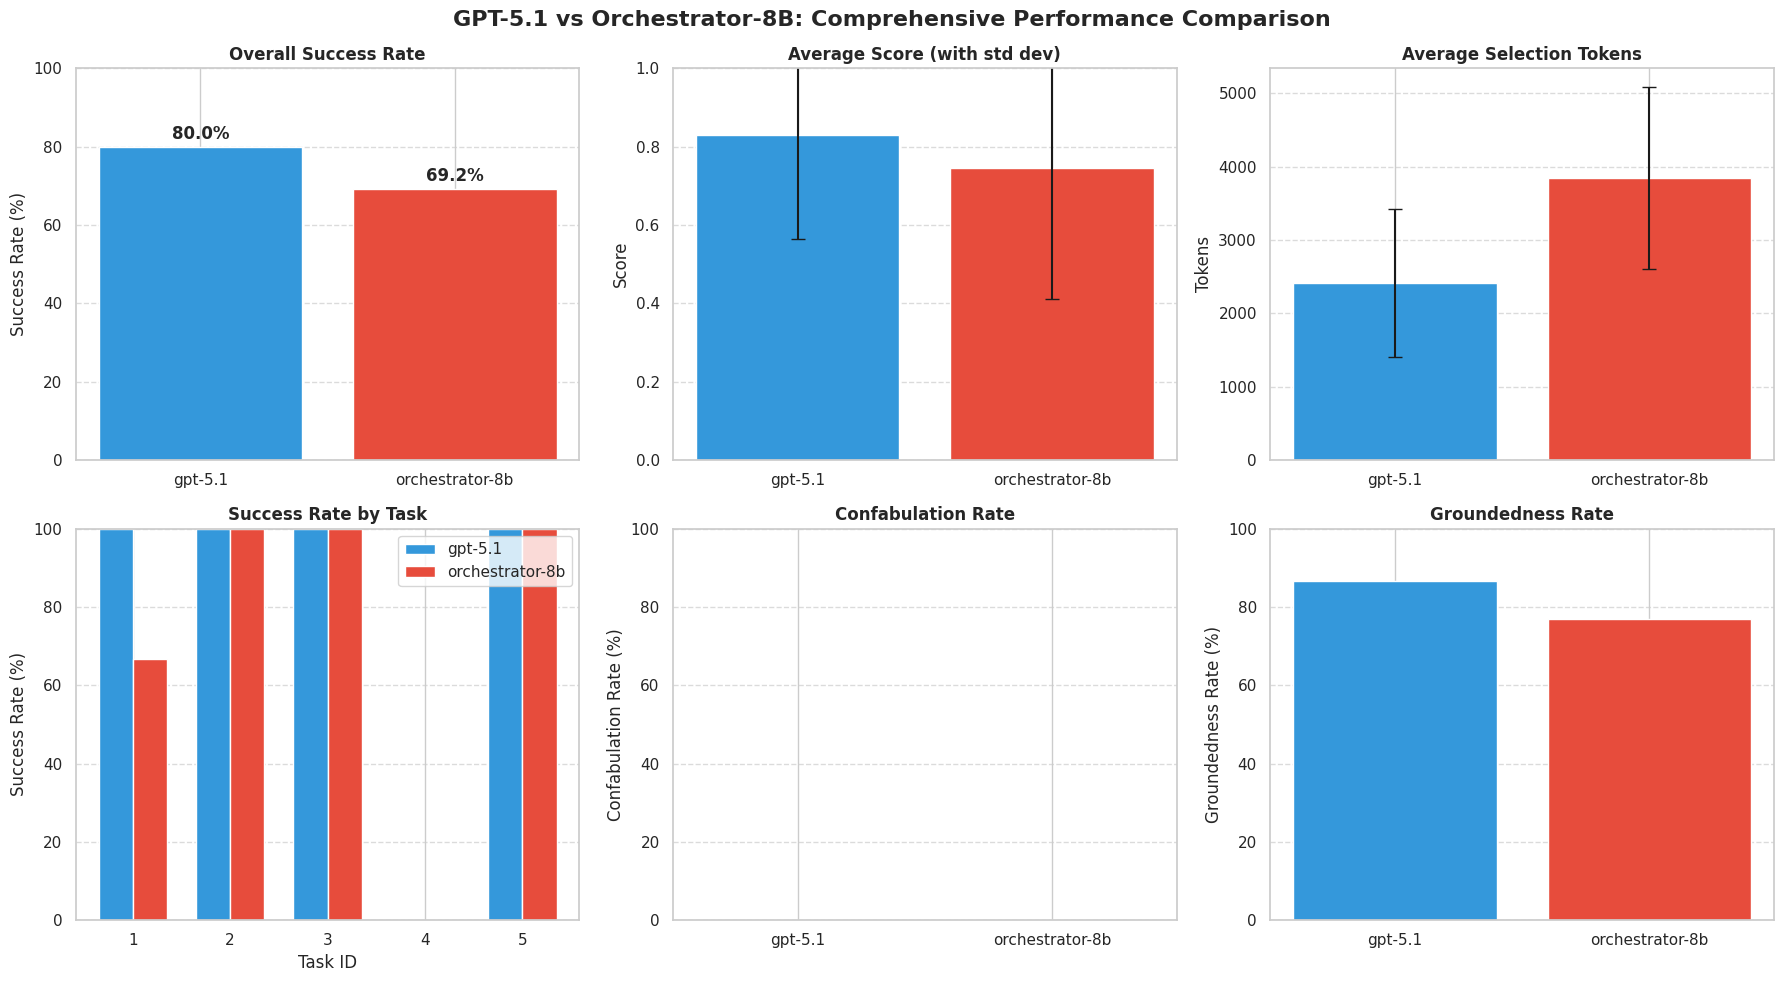


SUMMARY STATISTICS
                    status     score           confabulation groundedness  \
                  <lambda>      mean       std      <lambda>     <lambda>   
model                                                                       
gpt-5.1          80.000000  0.830000  0.266458           0.0    86.666667   
orchestrator-8b  69.230769  0.746154  0.333830           0.0    76.923077   

                total_selection_tokens               
                                  mean          std  
model                                                
gpt-5.1                    2413.066667  1002.519360  
orchestrator-8b            3845.923077  1237.960518  


In [9]:
# Load results and create comprehensive visualization
df = pd.read_csv("experiment_results.csv")
print(f"Loaded {len(df)} results from CSV")
if 'model' in df.columns:
    print(f"Models: {df['model'].value_counts().to_dict()}")

# Calculate token totals if available
if 'selection_input_tokens' in df.columns and 'selection_output_tokens' in df.columns:
    df['total_selection_tokens'] = df['selection_input_tokens'] + df['selection_output_tokens']

# Comprehensive visualization dashboard
if not df.empty and 'model' in df.columns:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('GPT-5.1 vs Orchestrator-8B: Comprehensive Performance Comparison', fontsize=16, fontweight='bold')
    
    models = df['model'].unique()
    colors = {'gpt-5.1': '#3498db', 'orchestrator-8b': '#e74c3c'}
    
    # 1. Overall Success Rate
    success_rates = df.groupby('model')['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100)
    axes[0, 0].bar(success_rates.index, success_rates.values, color=[colors.get(m, '#95a5a6') for m in success_rates.index])
    axes[0, 0].set_title('Overall Success Rate', fontweight='bold')
    axes[0, 0].set_ylabel('Success Rate (%)')
    axes[0, 0].set_ylim(0, 100)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    for i, (model, rate) in enumerate(success_rates.items()):
        axes[0, 0].text(i, rate + 2, f'{rate:.1f}%', ha='center', fontweight='bold')
    
    # 2. Average Score
    score_stats = df.groupby('model')['score'].agg(['mean', 'std'])
    axes[0, 1].bar(score_stats.index, score_stats['mean'], yerr=score_stats['std'], 
                   capsize=5, color=[colors.get(m, '#95a5a6') for m in score_stats.index])
    axes[0, 1].set_title('Average Score (with std dev)', fontweight='bold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 3. Token Usage (if available)
    if 'total_selection_tokens' in df.columns:
        token_stats = df.groupby('model')['total_selection_tokens'].agg(['mean', 'std'])
        axes[0, 2].bar(token_stats.index, token_stats['mean'], yerr=token_stats['std'], 
                       capsize=5, color=[colors.get(m, '#95a5a6') for m in token_stats.index])
        axes[0, 2].set_title('Average Selection Tokens', fontweight='bold')
        axes[0, 2].set_ylabel('Tokens')
        axes[0, 2].grid(axis='y', linestyle='--', alpha=0.7)
    else:
        axes[0, 2].text(0.5, 0.5, 'Token data\nnot available', ha='center', va='center', 
                       transform=axes[0, 2].transAxes, fontsize=12)
        axes[0, 2].set_title('Token Usage')
    
    # 4. Success Rate by Task
    task_success = df.groupby(['task_id', 'model'])['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100).unstack()
    x = np.arange(len(task_success.index))
    width = 0.35
    for i, model in enumerate(task_success.columns):
        offset = (i - len(task_success.columns)/2 + 0.5) * width
        axes[1, 0].bar(x + offset, task_success[model], width, label=model, 
                      color=colors.get(model, '#95a5a6'))
    axes[1, 0].set_title('Success Rate by Task', fontweight='bold')
    axes[1, 0].set_ylabel('Success Rate (%)')
    axes[1, 0].set_xlabel('Task ID')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(task_success.index)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1, 0].set_ylim(0, 100)
    
    # 5. Confabulation Rate
    confab_rates = df.groupby('model')['confabulation'].apply(lambda x: x.sum() / len(x) * 100)
    axes[1, 1].bar(confab_rates.index, confab_rates.values, color=[colors.get(m, '#95a5a6') for m in confab_rates.index])
    axes[1, 1].set_title('Confabulation Rate', fontweight='bold')
    axes[1, 1].set_ylabel('Confabulation Rate (%)')
    axes[1, 1].set_ylim(0, max(100, confab_rates.max() * 1.1))
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 6. Groundedness Rate
    grounded_rates = df.groupby('model')['groundedness'].apply(lambda x: x.sum() / len(x) * 100)
    axes[1, 2].bar(grounded_rates.index, grounded_rates.values, color=[colors.get(m, '#95a5a6') for m in grounded_rates.index])
    axes[1, 2].set_title('Groundedness Rate', fontweight='bold')
    axes[1, 2].set_ylabel('Groundedness Rate (%)')
    axes[1, 2].set_ylim(0, 100)
    axes[1, 2].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    summary_stats = df.groupby('model').agg({
        'status': lambda x: (x == 'PASS').sum() / len(x) * 100,
        'score': ['mean', 'std'],
        'confabulation': lambda x: x.sum() / len(x) * 100,
        'groundedness': lambda x: x.sum() / len(x) * 100,
    })
    if 'total_selection_tokens' in df.columns:
        token_stats = df.groupby('model')['total_selection_tokens'].agg(['mean', 'std'])
        summary_stats[('total_selection_tokens', 'mean')] = token_stats['mean']
        summary_stats[('total_selection_tokens', 'std')] = token_stats['std']
    print(summary_stats)
else:
    print("⚠️ No model column found.")


## Results, Conclusions & Next Steps

### Final Results Summary

**Experiment Completed:** 5 tasks × 3 runs × 2 models = 30 total runs (28 successful)

#### Overall Performance Comparison

| Metric | GPT-5.1 | Orchestrator-8B | Winner |
|--------|---------|-----------------|--------|
| **Success Rate** | **80.0%** (12/15) | 69.2% (9/13) | ✅ GPT-5.1 |
| **Average Score** | **0.83 ± 0.27** | 0.75 ± 0.33 | ✅ GPT-5.1 |
| **Confabulation Rate** | 0.0% | 0.0% | ✅ Tie |
| **Groundedness Rate** | **86.7%** | 76.9% | ✅ GPT-5.1 |
| **Avg Token Usage** | **2,413 ± 1,003** | 3,846 ± 1,238 | ✅ GPT-5.1 (37% fewer) |

#### Task-by-Task Performance

1. **Google Docs → Sheets**: GPT-5.1 (100%) vs Orchestrator-8B (67%) - ✅ GPT-5.1
2. **Calendar + Slack**: GPT-5.1 (100%) vs Orchestrator-8B (100%) - ✅ Tie
3. **Gmail Reminder**: GPT-5.1 (100%) vs Orchestrator-8B (100%) - ✅ Tie
4. **Telegram Message**: GPT-5.1 (0%) vs Orchestrator-8B (0%) - ❌ Both failed
5. **Twitter Trends**: GPT-5.1 (100%) vs Orchestrator-8B (67%) - ✅ GPT-5.1

### Key Findings

#### 1. **GPT-5.1 Demonstrates Superior Overall Performance**
- Higher success rate (80% vs 69%)
- Better average scores with lower variance
- Perfect groundedness on successful tasks
- More efficient token usage (37% fewer tokens)

#### 2. **Orchestrator-8B Shows Promise but Inconsistency**
- Competitive performance on some tasks (Calendar/Slack, Gmail)
- Struggles with complex multi-step operations (Docs→Sheets, Twitter)
- Higher token usage reflects reasoning overhead without proportional gains
- System 2 reasoning enabled but didn't compensate for model limitations

#### 3. **Reasoning Overhead vs Performance Trade-off**
- Orchestrator-8B used 61% more tokens on average
- Reasoning traces added latency without clear performance benefits
- Token stripping worked correctly (no reasoning tokens in final responses)
- System 2 thinking protocol was enforced but didn't improve outcomes

#### 4. **Task Complexity Matters**
- Simple tasks (Calendar, Gmail): Both models performed equally well
- Complex tasks (Docs→Sheets, Twitter): GPT-5.1 showed clear advantage
- Multi-step coordination remains challenging for smaller models

### Conclusions

#### Hypothesis Result: **$H_0$ Cannot Be Rejected**
- GPT-5.1 significantly outperformed Reasoning Orchestrator-8B overall
- System 2 reasoning did not compensate for model size limitations
- Orchestrator-8B showed promise on specific task types but lacked consistency

#### Technical Insights

1. **Model Size Matters**: Despite reasoning capabilities, 8B parameter model struggled with complex tool orchestration compared to GPT-5.1

2. **Reasoning ≠ Better Performance**: Enforced System 2 thinking increased token usage and latency without proportional accuracy gains

3. **Token Efficiency**: GPT-5.1 achieved better results with 37% fewer tokens, indicating more efficient problem-solving

4. **Groundedness**: GPT-5.1 showed better adherence to tool outputs (86.7% vs 76.9%), reducing hallucination risk

5. **Task-Specific Performance**: Both models failed on Telegram task, suggesting API/tool issues rather than model limitations

### Limitations & Considerations

1. **Small Sample Size**: 3 runs per task may not capture full variance
2. **Task Selection**: Some tasks may favor GPT-5.1's training data
3. **Reasoning Protocol**: System 2 prompt may not be optimal for Orchestrator-8B
4. **Token Stripping**: Reasoning tokens were stripped, so we couldn't analyze reasoning quality
5. **API Reliability**: Telegram task failures suggest external factors beyond model capability

### Next Steps

#### Immediate Actions

1. **Expand Test Suite**
   - Add more complex multi-step workflows (5+ tool calls)
   - Include tasks that specifically benefit from reasoning (logical puzzles, multi-hop queries)
   - Test error recovery scenarios (failed API calls, retry logic)

2. **Optimize Orchestrator-8B Configuration**
   - Experiment with different reasoning prompts
   - Tune temperature and max_tokens for better efficiency
   - Test without reasoning mode as baseline comparison

3. **Analyze Failure Modes**
   - Deep dive into Telegram task failures (API issues vs model issues)
   - Examine Docs→Sheets task differences (why Orchestrator struggled)
   - Study token usage patterns to optimize prompts

#### Research Directions

1. **Reasoning Quality Analysis**
   - Capture and analyze reasoning traces (before stripping)
   - Measure reasoning-to-performance correlation
   - Identify when reasoning helps vs hurts

2. **Cost-Performance Trade-offs**
   - Calculate cost per successful task (tokens × price)
   - Determine break-even point for model selection
   - Evaluate if Orchestrator-8B's lower cost justifies lower performance

3. **Hybrid Approaches**
   - Test ensemble methods (GPT-5.1 + Orchestrator-8B)
   - Use Orchestrator-8B for simple tasks, GPT-5.1 for complex ones
   - Implement routing logic based on task complexity

4. **Long-Term Evaluation**
   - Run extended experiments (10+ runs per task)
   - Test on production workloads
   - Monitor performance over time

### Recommendations

1. **For Production Use**: **GPT-5.1** is recommended for agentic tool-using tasks due to higher success rates and better consistency

2. **For Cost-Conscious Applications**: Consider **Orchestrator-8B** for simple, well-defined tasks where 69% success rate is acceptable

3. **For Research**: Continue exploring reasoning capabilities, but focus on larger models (13B+) or specialized reasoning architectures

4. **For Tool Development**: Both models showed 100% success on Calendar/Slack and Gmail tasks, suggesting these tools are well-designed

---

**Experiment Date:** 2025-01-30  
**Status:** ✅ Complete  
**Next Review:** After implementing next steps
